In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
from scipy import stats as sts
import shap
import spacy
nlp = spacy.load('en_core_web_lg')
from itertools import product


In [2]:
tag_users = pd.read_csv("tag_users.csv")
tag_questions = pd.read_csv("tag_questions.csv")
tags = pd.read_csv("tags.csv")
professionals = pd.read_csv("professionals.csv")
answers = pd.read_csv("answers.csv")
emails = pd.read_csv("emails.csv")
questions = pd.read_csv("questions.csv")
matches = pd.read_csv("matches.csv")
answers_scores = pd.read_csv("answer_scores.csv")
group_members = pd.read_csv("group_memberships.csv")
schools_members = pd.read_csv("school_memberships.csv")

In [3]:
def get_user_tags(user_id):
    user_tags = tag_users[tag_users["tag_users_user_id"] == user_id]["tag_users_tag_id"]
    tags_names =tags.loc[tags["tags_tag_id"].isin(user_tags)]
    return(tags)

In [4]:
def get_user_answers(user_id):
    all_answers = answers.loc[answers["answers_author_id"]==user_id]
    return all_answers

In [5]:
def match_email_question(email_date):
    f = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC+0000")
    b  =f(email_date)
    t = questions["questions_date_added"].apply(f)
    return questions.iloc[(b-t).abs().argsort()[:1]]

In [6]:
# get only emails that were sent immediately after getting the question (ignore the weekly newsletter emails)
immediate_emails = emails[emails["emails_frequency_level"]=="email_notification_immediate"]

# get the matches of the immediate emails only
immediate_matches = matches[matches["matches_email_id"].isin(immediate_emails["emails_id"])]
# get the emails that have their matches only (the data is missing the matches of some emails so we ignore those)
immediate_emails = immediate_emails[immediate_emails["emails_id"].isin(matches["matches_email_id"])]
# some renaming for convience
immediate_emails = immediate_emails.rename(columns={'emails_id':"id"})
immediate_matches = immediate_matches.rename(columns={'matches_email_id':"id"})

# let's put the emails and their matches question id:
emails_questions = pd.merge(immediate_emails, immediate_matches, how="left", on="id")
#some renaming:
emails_questions = emails_questions.rename(columns = {"matches_question_id": "question_id", "emails_recipient_id": "professional_id"})
answers = answers.rename(columns = {"answers_question_id": "question_id", "answers_author_id": "professional_id"})

# now, let's make a big data that has emails, questions sent, and answers. Note that some professionals provided more than
# one answer to the same question. So this means the email Id will be repeated because it has two answers
full_data = pd.merge(emails_questions, answers,how='left',  on=["professional_id","question_id" ])
full_data = full_data.rename(columns = {"id": "email_id"})

# get the target variable by looking ad the answer and putting 1 if it exists and 0 if not:
target = full_data['answers_id'].fillna(0)
target = pd.to_numeric(target, errors='coerce').fillna(1).astype(int) #here just turn str to NA then replace with 1
full_data["q_answered?"] = target

# turn the email sent date into a datetime value instead of a string
date_vectorizer = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC+0000")
full_data["emails_date_sent"] = full_data["emails_date_sent"].apply(date_vectorizer)
# turn the asnwer added data to datetime value instead of a string (while ignoring the NAs)
indices = full_data["answers_date_added"][full_data["answers_date_added"].notnull()].index.values
full_data.loc[indices, "answers_date_added"] = full_data["answers_date_added"][full_data["answers_date_added"].notnull()].apply(date_vectorizer)
#adding the time taken for each professional to answer a question
full_data["time_taken"] =  pd.to_datetime(full_data["answers_date_added"]) - pd.to_datetime(full_data["emails_date_sent"])


# some people were too active and answered the question even before the email was sent to them. So that would lead
# to a negative time_taken. So we fix that by putting a zero for the time they took (they answered it immediately)
indices2 = full_data["time_taken"][full_data["time_taken"] < datetime.timedelta( days=0)].index.values
full_data.loc[indices2, "time_taken"]=datetime.timedelta(days=0, seconds=0,minutes=0, hours=0 )

# get all the tags of each question
tag_questions_names = pd.merge(tag_questions.rename(columns = {"tag_questions_tag_id":"tag_id"}), tags.rename(columns = {"tags_tag_id":"tag_id"}),how='left',  on=["tag_id" ])
tag_questions_names = tag_questions_names.rename(columns ={"tag_questions_question_id":"question_id", "tags_tag_name":"tag_name"})
questions_tags = tag_questions_names.groupby("question_id")["tag_name"].apply(list).reset_index(name="q_tags")
full_data = pd.merge(full_data,questions_tags,how='left',  on=["question_id" ])

In [7]:
# creating a data for all the professionals
professionals_dataset = pd.DataFrame(columns = ["professional_id"])
professionals_dataset["professional_id"] = professionals["professionals_id"]
# getting the response rate by counting the number of questions answered after the email was sent
response = full_data.groupby("professional_id").mean().drop(columns = ["email_id"]).reset_index()
professionals_dataset = pd.merge(professionals_dataset, response,how='left',  on=["professional_id" ])
professionals_dataset = professionals_dataset.rename(columns = {"q_answered?": "response_rate"})


# getting the average time they took to answer the question if they did
grouped = full_data.groupby('professional_id')["time_taken"]
time_mean = grouped.apply(lambda x: np.mean(x))
professionals_dataset = pd.merge(professionals_dataset, time_mean,how='left',  on=["professional_id" ])
professionals_dataset=  professionals_dataset.rename(columns ={"time_taken": "avg_time_taken"})

# count the total number of questions that each professional answered (including those answered after email)
answers_count = answers["professional_id"].value_counts().reset_index().rename(columns = {"professional_id":"number_q_answered","index":"professional_id",  })
professionals_dataset = pd.merge(professionals_dataset, answers_count,how='left',  on=["professional_id" ])
professionals_dataset["number_q_answered"]= professionals_dataset["number_q_answered"].fillna(0)

# get all the tags that each professional is following
all_tags = pd.merge(tag_users.rename(columns = {"tag_users_tag_id": "tag_id"}),tags.rename(columns = {"tags_tag_id": "tag_id"}),how='left',  on=["tag_id" ])
foll_tags = all_tags.groupby('tag_users_user_id')['tags_tag_name'].apply(lambda x: list(set(x))).reset_index(name='following_tags').rename(columns = {"tag_users_user_id": "professional_id"})
professionals_dataset = pd.merge(professionals_dataset, foll_tags,how='left',  on=["professional_id" ])
# get all the tags of the questions that he answered before
a = full_data[["professional_id","q_tags"]][full_data["q_tags"].notnull()].groupby("professional_id")["q_tags"].agg(sum).apply(lambda x: list(set(x)))
professionals_dataset = pd.merge(professionals_dataset, a,how='left',  on=["professional_id" ])
professionals_dataset = professionals_dataset.rename(columns = {"q_tags": "prev_q_tags"})
# get the average score for each professional

prof_score = pd.merge(answers[["professional_id","answers_id" ]], answers_scores.rename(columns = {"id":"answers_id"}),how='left',  on=["answers_id" ]).drop(columns = ["answers_id"])
score_mean = prof_score.groupby("professional_id").mean().reset_index()
professionals_dataset = pd.merge(professionals_dataset,score_mean,how='left',  on=["professional_id" ]).rename(columns = {"score":"avg_ansrs_score"})
professionals_dataset["avg_ansrs_score"] = professionals_dataset["avg_ansrs_score"].fillna(0)
# get the number of groups that each professional is following
prof_grp = group_members["group_memberships_user_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "group_memberships_user_id":"num_groups"})
professionals_dataset = pd.merge(professionals_dataset,prof_grp,how='left',  on=["professional_id" ])
# get the number of schools that each professional is following
prof_schl = schools_members["school_memberships_user_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "school_memberships_user_id":"num_schools"})
professionals_dataset = pd.merge(professionals_dataset,prof_schl,how='left',  on=["professional_id" ])
#get the answers to email ratio (#answers/#emails sent) for each professional

prof_emls = immediate_emails["emails_recipient_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "emails_recipient_id":"num_emails"})
professionals_dataset = pd.merge(professionals_dataset,prof_emls,how='left',  on=["professional_id" ])
professionals_dataset["answrs_emails_ratio"] = professionals_dataset["number_q_answered"] / professionals_dataset["num_emails"]


In [8]:
full_data.head(1)

,Unnamed: 0_x,email_id,professional_id,emails_date_sent,emails_frequency_level,Unnamed: 0_y,question_id,answers_id,answers_date_added,answers_body,q_answered?,time_taken,q_tags
0,292,508143,0c673e046d824ec0ad0ebe012a0673e4,2016-05-20 20:07:48,email_notification_immediate,3291613,b551946952ae4328864414a9164a95d8,NaN,NaN,NaN,0,NaT,"[guidance-counselor, school-counselor, school,..."


In [9]:
professionals_dataset.head(1)

,professional_id,Unnamed: 0_x,Unnamed: 0_y,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,NaT,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [10]:

def Intersection(topics1, topics2):
    """
    Number of topics in common
    """
    return len(set(topics1).intersection(topics2))
def IoU(topics1, topics2): 
    """
    Intersection over Union: number of intersecting topics over the total number of topics
    
    """
    return (len(set(topics1).intersection(topics2))/ (len(topics1)+len(topics2)))
def IoI(topics1, topics2):
    """
    Intersection over Interest: number of intersecting topics over the number of topics of the prof's interest
    """
    return (len(set(topics1).intersection(topics2))/ (len(topics1)))

In [11]:
model_dataset = pd.merge(full_data,professionals_dataset,how='left',  on=["professional_id" ])

In [12]:
model_dataset["following_tags"]= model_dataset["following_tags"].fillna("Na")
model_dataset["prev_q_tags"]= model_dataset["prev_q_tags"].fillna("Na")
model_dataset["q_tags"]= model_dataset["q_tags"].fillna("Na")

In [13]:
model_dataset.head(1)

,Unnamed: 0_x_x,email_id,professional_id,emails_date_sent,emails_frequency_level,Unnamed: 0_y_x,question_id,answers_id,answers_date_added,answers_body,...,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio
0,292,508143,0c673e046d824ec0ad0ebe012a0673e4,2016-05-20 20:07:48,email_notification_immediate,3291613,b551946952ae4328864414a9164a95d8,NaN,NaN,NaN,...,0.0,NaT,39.0,"[career-choice, air-force, education, consulti...","[financial-planning, professor, economics, com...",1.974359,NaN,NaN,70.0,0.557143


In [14]:
model_dataset.columns

Index(['Unnamed: 0_x_x', 'email_id', 'professional_id', 'emails_date_sent',
       'emails_frequency_level', 'Unnamed: 0_y_x', 'question_id', 'answers_id',
       'answers_date_added', 'answers_body', 'q_answered?', 'time_taken',
       'q_tags', 'Unnamed: 0_x_y', 'Unnamed: 0_y_y', 'response_rate',
       'avg_time_taken', 'number_q_answered', 'following_tags', 'prev_q_tags',
       'avg_ansrs_score', 'num_groups', 'num_schools', 'num_emails',
       'answrs_emails_ratio'],
      dtype='object')

In [29]:
#model_dataset = model_dataset.drop(columns = ["email_id", "professional_id", "emails_date_sent", "emails_frequency_level",
#                              "question_id", "answers_id", "answers_date_added", "answers_body", "time_taken",
#                              "q_tags", "following_tags", "prev_q_tags"])


model_dataset = model_dataset.drop(columns = ["Unnamed: 0_x_x","Unnamed: 0_x_y","Unnamed: 0_y_x","Unnamed: 0_y_y","email_id", "professional_id", "emails_date_sent", "emails_frequency_level",
                              "question_id", "answers_id", "answers_date_added", "answers_body", "time_taken"])

KeyError: "['email_id' 'professional_id' 'emails_date_sent' 'emails_frequency_level'\n 'question_id' 'answers_id' 'answers_date_added' 'answers_body'\n 'time_taken'] not found in axis"

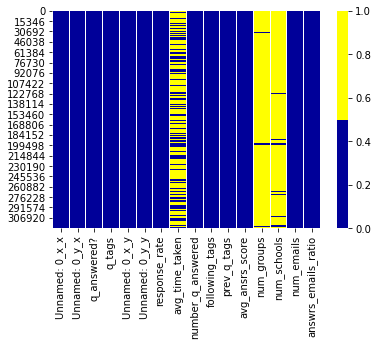

In [16]:
cols = model_dataset.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(model_dataset[cols].isnull(), cmap=sns.color_palette(colours))

In [17]:
model_dataset["num_schools"]  =model_dataset["num_schools"].fillna(0)
model_dataset["num_groups"] = model_dataset["num_groups"].fillna(0)

In [18]:
model_dataset["avg_time_taken"]= model_dataset["avg_time_taken"][model_dataset["avg_time_taken"].notnull()].apply(lambda x: x.total_seconds()/3600)

In [19]:
model_dataset["avg_time_taken"].describe()

count    112383.000000
mean        212.373288
std         971.146922
min           0.000000
25%           2.229907
50%          11.692668
75%          47.353889
max       12390.666667
Name: avg_time_taken, dtype: float64

In [20]:
med = model_dataset["avg_time_taken"].median()
model_dataset["avg_time_taken"] = model_dataset["avg_time_taken"].fillna(med)

In [21]:
positive = model_dataset[ model_dataset["q_answered?"] != 0]
negative = model_dataset[ model_dataset["q_answered?"] == 0]

In [22]:
negative_sample = negative.sample(5000)

In [23]:
resampled_data = pd.concat([positive,negative_sample ])

In [24]:
follow_I = resampled_data.apply(lambda x: Intersection(x.following_tags, x.q_tags), axis=1)
follow_IoI = resampled_data.apply(lambda x: IoI(x.following_tags, x.q_tags), axis=1)
follow_IoU = resampled_data.apply(lambda x: IoU(x.following_tags, x.q_tags), axis=1)

prev_I = resampled_data.apply(lambda x: Intersection(x.prev_q_tags, x.q_tags), axis=1)

resampled_data["follow_I"]=follow_I
resampled_data["follow_IoI"]=follow_IoI
resampled_data["follow_IoU"]=follow_IoU
resampled_data["prev_I"]=prev_I

In [25]:
resampled_data = resampled_data.drop(columns = ["following_tags", "q_tags", "prev_q_tags"])

In [26]:
target = resampled_data["q_answered?"]
resampled_data = resampled_data.drop(columns = ["q_answered?"])

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [28]:
x_train, x_test, y_train, y_test = train_test_split(resampled_data, target, test_size=0.2, random_state=42)

In [30]:
LR = LogisticRegression(max_iter = 10000)
LR.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

In [31]:
LR.score(x_train, y_train)

0.8407382992748846

In [32]:
LR.score(x_test, y_test)

0.8365840801265155

In [33]:
#LR.classes_
LR.predict_proba(x_test)

array([[8.93720395e-01, 1.06279605e-01],
       [4.29343476e-01, 5.70656524e-01],
       [8.49159864e-01, 1.50840136e-01],
       ...,
       [7.32202705e-01, 2.67797295e-01],
       [2.46687413e-01, 7.53312587e-01],
       [4.01206111e-04, 9.99598794e-01]])

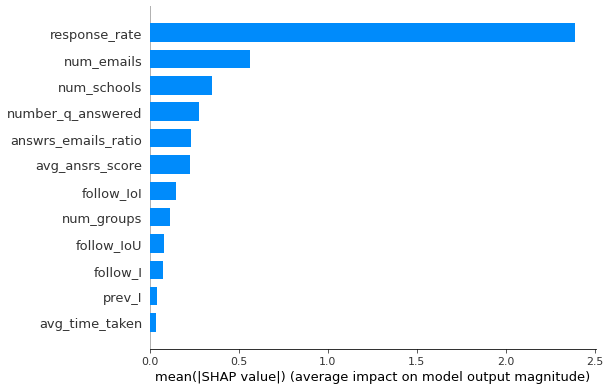

In [34]:
explainer = shap.LinearExplainer(LR, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_train, plot_type="bar")

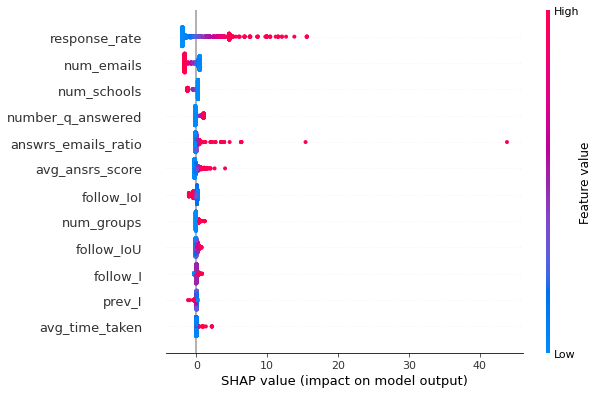

In [35]:
shap.summary_plot(shap_values, x_test)

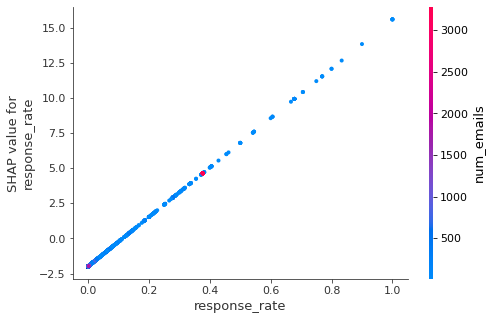

In [36]:
shap.dependence_plot("response_rate", shap_values, x_test)

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], x_test.iloc[0,:])

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn import datasets
from tensorflow import keras
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu')) # 12 neurons and expecting 8 columns x
model.add(Dense(8, activation='relu'))#8 neurons with activation function rectified
model.add(Dense(8, activation='relu'))#8 neurons with activation function rectified
model.add(Dense(1, activation='sigmoid')) #1 neuron with sigmoid activation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(x_train, y_train, epochs = 100)


Epoch 1/100
7585/7585 [==============================] - 0s 59us/step - loss: 1.3995 - accuracy: 0.7933
Epoch 2/100
7585/7585 [==============================] - 0s 29us/step - loss: 0.8154 - accuracy: 0.8094
Epoch 3/100
7585/7585 [==============================] - 0s 30us/step - loss: 0.7148 - accuracy: 0.8253
Epoch 4/100
7585/7585 [==============================] - 0s 33us/step - loss: 0.6860 - accuracy: 0.8277
Epoch 5/100
7585/7585 [==============================] - 0s 28us/step - loss: 0.4985 - accuracy: 0.8390
Epoch 6/100
7585/7585 [==============================] - 0s 32us/step - loss: 0.5185 - accuracy: 0.8427
Epoch 7/100
7585/7585 [==============================] - 0s 30us/step - loss: 0.4772 - accuracy: 0.8538
Epoch 8/100
7585/7585 [==============================] - 0s 39us/step - loss: 0.4850 - accuracy: 0.8494
Epoch 9/100
7585/7585 [==============================] - 0s 35us/step - loss: 0.4456 - accuracy: 0.8497
Epoch 10/100
7585/7585 [==============================] - 0s 37

In [44]:
#accuracy
model.evaluate(x_test, y_test, verbose = True)[1]

1897/1897 [==============================] - 0s 32us/step


0.87928307056427